In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [4]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1950]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1242372


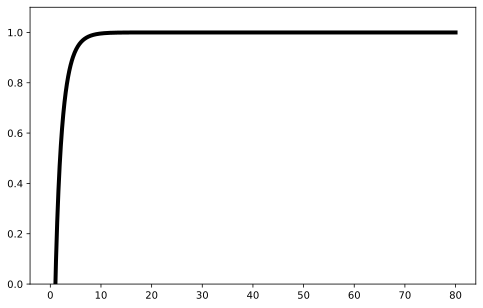

In [28]:
### Academic age distribution
from scipy.special import gammaincc
fig, ax = plt.subplots(figsize=(8, 5))
a = 0.6
b = 0.5
def pdf(x,a,b):
    norm = (b**(a-1))*gammaincc(1-a,b)
    return (1/norm)*np.exp(-b*x)*x**(-a)

def cdf(x,a,b):
    norm = gammaincc(1-a,b)
    return (1/norm)*(gammaincc(1-a,b) - gammaincc(1-a,b*x))

x_life = np.linspace(0,80,1001)
f_life = cdf(x_life,a,b)
x_life[1000] = 80
f_life[1000] = 1
plt.plot(x_life,f_life,color="black",linestyle="-",linewidth=4)
plt.ylim(0,1.1)

all_ages = []
for i in range(len(all_authors)):
    i_a = np.random.rand()
    age = np.where(f_life > i_a)[0][0]
    all_ages.append(age-20)

In [30]:
t0 = 1950
tf = 1970

# Not all authors at the reservoir
N_a = 100
authors = np.array(all_authors[0:N_a])
ages = np.array(all_ages[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = (np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 20 # Number of simplices at t0

# Memory matrix
M = np.ones((N_a,N_a)) - np.identity(N_a)

# If the ages are < 0 or > age_max, we set M = 0
age_max = 80
for i in range(N_a):
    M[i,ages < 0] = 0
    M[ages < 0,i] = 0
    M[i,ages > age_max] = 0
    M[ages > age_max,i] = 0

ti = t0

simplices = []
time = []

def p(x):
    return 1/(1+x)

def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-10)))
    Z = np.sum([np.exp(-alpha*o) for o in range(N)])
    e = np.exp(-alpha*order)/Z
    lam = N/2
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return alpha*e + (1-alpha)*Pois

w_t = 0
while ti < tf:
    # Compute total rate:
    W = (r+1)*N_simplices
    
    # Compute next event time
    At = - np.log(np.random.rand())/W

    ti = ti + At
    w_t = w_t + At
    ages = ages + At

    # Choose main author according to the age
    i_a = np.random.randint(0,N_a)
    while np.random.rand() > p(ages[i_a]):
        i_a = np.random.randint(0,N_a)
    
    # i_a is the main author
    age = ages[i_a]
    o_i = np.random.choice(range(N),p=[dist_order(order,age,N) for order in range(N)]/np.sum([dist_order(order,age,N) for order in range(N)]))
    
    if o_i > 0:
        possible_collaborators_index = list(range(N_a))
        # random choice from authors to select the collaborators
        if np.sum(M[i_a,:]) > 0:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False,p=M[i_a,:]/np.sum(M[i_a,:]))
        else:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
        for i in i_c:
            M[i_a,i] = M[i_a,i] + 1
            M[i,i_a] = M[i,i_a] + 1
            for j in i_c:
                M[i,j] = M[i,j] + 1
                M[j,i] = M[j,i] + 1
        simplices.append([authors[i_a]] + collaborators)
        time.append(ti)
    else:
        simplices.append([authors[i_a]])
        time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

ValueError: Fewer non-zero entries in p than size

In [15]:
simplices

[[28.0, 25.0],
 [31.0],
 [57.0, 28.0],
 [6.0],
 [44.0],
 [39.0],
 [64.0],
 [57.0, 28.0, 37.0, 4.0, 32.0],
 [86.0],
 [64.0, 87.0, 49.0],
 [39.0],
 [64.0, 23.0, 10.0, 84.0],
 [3.0, 8.0, 95.0, 85.0, 40.0],
 [20.0],
 [90.0, 34.0, 31.0],
 [49.0, 29.0],
 [54.0],
 [84.0, 53.0],
 [48.0, 12.0],
 [87.0, 21.0],
 [33.0, 92.0],
 [54.0, 70.0, 77.0, 39.0],
 [40.0, 8.0],
 [77.0],
 [11.0, 97.0],
 [77.0, 11.0, 59.0, 54.0, 70.0],
 [74.0],
 [38.0, 24.0],
 [64.0, 17.0, 62.0],
 [28.0],
 [102.0, 48.0],
 [33.0, 77.0],
 [64.0, 87.0],
 [17.0, 51.0, 14.0, 64.0],
 [17.0, 34.0],
 [16.0],
 [51.0],
 [18.0, 7.0],
 [32.0],
 [37.0],
 [35.0],
 [17.0],
 [94.0],
 [5.0, 35.0],
 [2.0],
 [55.0, 80.0, 64.0],
 [51.0],
 [86.0],
 [53.0, 9.0],
 [31.0],
 [54.0],
 [61.0],
 [89.0],
 [48.0],
 [74.0, 98.0, 45.0],
 [74.0, 70.0],
 [18.0],
 [33.0, 47.0],
 [80.0],
 [61.0, 90.0],
 [75.0, 74.0],
 [57.0],
 [77.0],
 [36.0],
 [35.0],
 [50.0],
 [17.0, 1.0, 94.0],
 [86.0, 26.0],
 [57.0],
 [90.0],
 [9.0, 102.0],
 [63.0, 90.0],
 [77.0],
 [24.0, 64